# 1. Importing

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix, f1_score, precision_score, recall_score
from sklearn import datasets, linear_model, preprocessing
from sklearn.model_selection import train_test_split

import keras
import keras.backend as K
from keras.models import Model, Sequential
from keras.layers import Dense, Activation
from keras.utils.vis_utils import plot_model
from IPython.display import clear_output
from keras import optimizers
from keras.models import load_model
from keras.callbacks import Callback

%matplotlib inline


Using TensorFlow backend.


# 2. Investigating the Data


In [2]:
features = ['MIP', 'SIP','EKIP','SKIP','MDM-SR','SDM-SR','EKDM-SR','SKDM-SR','Target'] # Abbreviating features
df =  pd.read_csv('pulsar_stars.csv',
                names=features,na_values='?',header=None, skiprows = 1)
print(df.head(6))

          MIP        SIP      EKIP      SKIP    MDM-SR     SDM-SR    EKDM-SR  \
0  140.562500  55.683782 -0.234571 -0.699648  3.199833  19.110426   7.975532   
1  102.507812  58.882430  0.465318 -0.515088  1.677258  14.860146  10.576487   
2  103.015625  39.341649  0.323328  1.051164  3.121237  21.744669   7.735822   
3  136.750000  57.178449 -0.068415 -0.636238  3.642977  20.959280   6.896499   
4   88.726562  40.672225  0.600866  1.123492  1.178930  11.468720  14.269573   
5   93.570312  46.698114  0.531905  0.416721  1.636288  14.545074  10.621748   

      SKDM-SR  Target  
0   74.242225       0  
1  127.393580       0  
2   63.171909       0  
3   53.593661       0  
4  252.567306       0  
5  131.394004       0  


In [3]:
# Checking information about the dtypes and non-null rows in the dataset
df.info()
print('\n Since dtypes are all floating point numbers or integers, and there are no null values in the dataset \n No need to perform cleaning')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17898 entries, 0 to 17897
Data columns (total 9 columns):
MIP        17898 non-null float64
SIP        17898 non-null float64
EKIP       17898 non-null float64
SKIP       17898 non-null float64
MDM-SR     17898 non-null float64
SDM-SR     17898 non-null float64
EKDM-SR    17898 non-null float64
SKDM-SR    17898 non-null float64
Target     17898 non-null int64
dtypes: float64(8), int64(1)
memory usage: 1.2 MB

 Since dtypes are all floating point numbers or integers, and there are no null values in the dataset 
 No need to perform cleaning


In [4]:
# Getting the statistical details of the dataset
df.describe()

,MIP,SIP,EKIP,SKIP,MDM-SR,SDM-SR,EKDM-SR,SKDM-SR,Target
count,17898.000000,17898.000000,17898.000000,17898.000000,17898.000000,17898.000000,17898.000000,17898.000000,17898.000000
mean,111.079968,46.549532,0.477857,1.770279,12.614400,26.326515,8.303556,104.857709,0.091574
std,25.652935,6.843189,1.064040,6.167913,29.472897,19.470572,4.506092,106.514540,0.288432
min,5.812500,24.772042,-1.876011,-1.791886,0.213211,7.370432,-3.139270,-1.976976,0.000000
25%,100.929688,42.376018,0.027098,-0.188572,1.923077,14.437332,5.781506,34.960504,0.000000
50%,115.078125,46.947479,0.223240,0.198710,2.801839,18.461316,8.433515,83.064556,0.000000
75%,127.085938,51.023202,0.473325,0.927783,5.464256,28.428104,10.702959,139.309331,0.000000
max,192.617188,98.778911,8.069522,68.101622,223.392140,110.642211,34.539844,1191.000837,1.000000


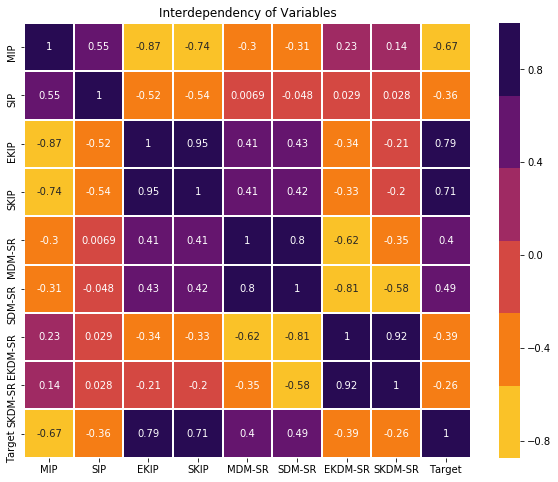

In [5]:
correlation = df.corr()
plt.figure(figsize=(10,8))
sns.heatmap(correlation,annot=True,
            cmap=sns.color_palette("inferno_r"),
            linewidth=1,edgecolor="k")
plt.title("Interdependency of Variables")
plt.show()

# 3. Pre-Processing Data

In [6]:
# Changing dataframe to array and separating target values from feature values
pulsar_x= np.array((df.loc[:,'MIP':'SKDM-SR']))
pulsar_y= np.array((df.loc[:,'Target']))
pulsar_x=pulsar_x.reshape(pulsar_x.shape[0],8)
pulsar_y=pulsar_y.reshape(pulsar_y.shape[0],1)
print(pulsar_x.shape)
print(pulsar_y.shape)


(17898, 8)
(17898, 1)


In [7]:
# Scaling Data
x_scale = preprocessing.scale(pulsar_x)
# splitting data into a 75:25 train test split
x_train, x_test, y_train, y_test = train_test_split(x_scale, pulsar_y, test_size = .25)
y_train = y_train.reshape((y_train.shape[0]), 1)
print(y_train.shape)
print(x_train.shape)
print(y_test.shape)

(13423, 1)
(13423, 8)
(4475, 1)


# 4. Logistic Regression Without Feature Transformation

##  4.1 With L1 Regularization:

In [8]:
# Initializing lists for different accuracy values for train and test sets corresponding to different values of parameter C
acc_train_logreg = [] 
acc_test_logreg = []
Yhat_test_logreg = []
c_logreg = []
prec_test_logreg = []
fscore_test_logreg =[]

In [9]:
def logreg_model_L1(c , X_train, Y_train, X_test, Y_test):

    logreg = linear_model.LogisticRegression(C=c,penalty='l1', warm_start=True, solver='saga', max_iter = 5000)
    
    logreg.fit(X_train, Y_train)
    
    Yhat_train = logreg.predict(X_train)
    
  
    # Adding training accuracy to acc_train_logreg
    acc_train = np.mean(Yhat_train == Y_train)
    acc_train_logreg.append(acc_train)
    
    # Printing values of C and no. of iterations
    print("For C = %f" % c)
    print("Accuracy on training data = %f" % acc_train)

    Yhat_test = logreg.predict(X_test)
    # Adding testing accuracy to acc_test_logreg
    acc_test = np.mean(Yhat_test == Y_test)
    acc_test_logreg.append(acc_test)
    print("Accuracy on test data = %f" % acc_test)
    prec , recal , fscore,_ = precision_recall_fscore_support(Y_test, Yhat_test, average = 'weighted')
    prec_test_logreg.append(prec)
    fscore_test_logreg.append(fscore)
    print("Precision on test data = %f" % prec)
    print("Recal on test data = %f" % recal)
    print("fscore on test data = %f" % fscore)

    # Appending value of c for graphing purposes
    c_logreg.append(c)
    Yhat_test_logreg.append(Yhat_test)

In [10]:
# Call the above function i.e. logreg_model with different values of parameter 'c'.
c_values = [0.0001, 0.001, 0.01, 0.1, 1, 10,100]

for c in c_values:
    logreg_model_L1(c, x_train, y_train, x_test, y_test)    
    

C:\Users\zafir\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


For C = 0.000100
Accuracy on training data = 0.909856
Accuracy on test data = 0.904134
Precision on test data = 0.817458
Recal on test data = 0.904134
fscore on test data = 0.858614


C:\Users\zafir\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\zafir\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


For C = 0.001000
Accuracy on training data = 0.876574
Accuracy on test data = 0.867830
Precision on test data = 0.950391
Recal on test data = 0.948156
fscore on test data = 0.939486


C:\Users\zafir\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


For C = 0.010000
Accuracy on training data = 0.850376
Accuracy on test data = 0.843627
Precision on test data = 0.971903
Recal on test data = 0.972291
fscore on test data = 0.970745


C:\Users\zafir\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


For C = 0.100000
Accuracy on training data = 0.846407
Accuracy on test data = 0.838931
Precision on test data = 0.977290
Recal on test data = 0.977654
fscore on test data = 0.976785


C:\Users\zafir\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


For C = 1.000000
Accuracy on training data = 0.844819
Accuracy on test data = 0.836944
Precision on test data = 0.978834
Recal on test data = 0.979218
fscore on test data = 0.978551


C:\Users\zafir\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


For C = 10.000000
Accuracy on training data = 0.844941
Accuracy on test data = 0.836583
Precision on test data = 0.979292
Recal on test data = 0.979665
fscore on test data = 0.979037


C:\Users\zafir\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


For C = 100.000000
Accuracy on training data = 0.844941
Accuracy on test data = 0.836583
Precision on test data = 0.979292
Recal on test data = 0.979665
fscore on test data = 0.979037


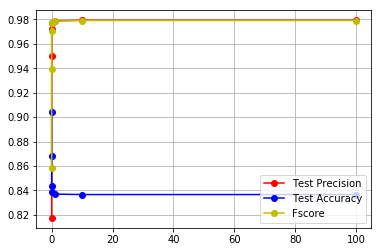

In [11]:
plt.plot(c_logreg, prec_test_logreg, 'ro-') 
plt.plot(c_logreg, acc_test_logreg,'bo-') 
plt.plot(c_logreg, fscore_test_logreg,'yo-') 
plt.grid()
# Use the following function to have a legend
plt.legend(['Test Precision', 'Test Accuracy', 'Fscore'], loc='lower right')

## 4.2 With L2 Regularization

In [12]:
acc_train_logreg_L2 = [] 
acc_test_logreg_L2 = []
Yhat_test_logreg_L2 = []
c_logreg_L2 = []
prec_test_logreg.clear()
fscore_test_logreg.clear()
print(prec_test_logreg)


[]


In [13]:
def logreg_model_L2(c , X_train, Y_train, X_test, Y_test):
    
  
    logreg = linear_model.LogisticRegression(C=c, warm_start=True, solver='saga', max_iter = 5000)
    
    logreg.fit(X_train, Y_train)
    
    Yhat_train = logreg.predict(X_train)
    
  
    # Adding training accuracy to acc_train_logreg
    acc_train = np.mean(Yhat_train == Y_train)
    acc_train_logreg_L2.append(acc_train)
    
    # Printing values of C and no. of iterations
    print("For C = %f" % c)
    print("Accuracy on training data = %f" % acc_train)

    Yhat_test = logreg.predict(X_test)
    # Adding testing accuracy to acc_test_logreg
    acc_test = np.mean(Yhat_test == Y_test)
    acc_test_logreg_L2.append(acc_test)
    print("Accuracy on test data = %f" % acc_test)
    prec , recal , fscore,_ = precision_recall_fscore_support(Y_test, Yhat_test, average = 'weighted')
    prec_test_logreg.append(prec)
    fscore_test_logreg.append(fscore)
    print("Precision on test data = %f" % prec)
    print("Recal on test data = %f" % recal)
    print("fscore on test data = %f" % fscore)
    
    # Appending value of c for graphing purposes
    c_logreg_L2.append(c)
    Yhat_test_logreg_L2.append(Yhat_test)

In [14]:
c_values = [0.0001, 0.001, 0.01, 0.1, 1, 10,100]

for c in c_values:
    logreg_model_L2(c, x_train, y_train, x_test, y_test)  

C:\Users\zafir\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


For C = 0.000100
Accuracy on training data = 0.893918
Accuracy on test data = 0.886253
Precision on test data = 0.931818
Recal on test data = 0.926257
fscore on test data = 0.904657


C:\Users\zafir\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


For C = 0.001000
Accuracy on training data = 0.863994
Accuracy on test data = 0.856270
Precision on test data = 0.960744
Recal on test data = 0.960223
fscore on test data = 0.955919


C:\Users\zafir\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


For C = 0.010000
Accuracy on training data = 0.850926
Accuracy on test data = 0.844711
Precision on test data = 0.970551
Recal on test data = 0.970950
fscore on test data = 0.969211


C:\Users\zafir\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


For C = 0.100000
Accuracy on training data = 0.847506
Accuracy on test data = 0.839111
Precision on test data = 0.976577
Recal on test data = 0.976983
fscore on test data = 0.976074


C:\Users\zafir\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


For C = 1.000000
Accuracy on training data = 0.845308
Accuracy on test data = 0.837486
Precision on test data = 0.978148
Recal on test data = 0.978547
fscore on test data = 0.977820


C:\Users\zafir\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


For C = 10.000000
Accuracy on training data = 0.844941
Accuracy on test data = 0.836763
Precision on test data = 0.979063
Recal on test data = 0.979441
fscore on test data = 0.978794


C:\Users\zafir\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


For C = 100.000000
Accuracy on training data = 0.844941
Accuracy on test data = 0.836583
Precision on test data = 0.979292
Recal on test data = 0.979665
fscore on test data = 0.979037


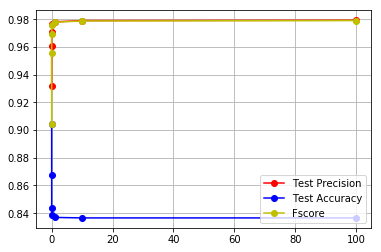

In [15]:
plt.plot(c_logreg_L2, prec_test_logreg, 'ro-') 
plt.plot(c_logreg_L2, acc_test_logreg,'bo-') 
plt.plot(c_logreg_L2, fscore_test_logreg,'yo-') 
plt.grid()
# Use the following function to have a legend
plt.legend(['Test Precision', 'Test Accuracy','Fscore'], loc='lower right')

# 4.3 Logistic Regression using Polynomial Feature Transformation
## 4.3.1 Using L1 Regularization without PCA

In [16]:
from sklearn.preprocessing import PolynomialFeatures

In [17]:
ply = PolynomialFeatures(degree = 2)

In [18]:
X_transformed_train = ply.fit_transform(x_train)
X_transformed_test = ply.fit_transform(x_test)
print(X_transformed_train.shape)
print(X_transformed_test.shape)

(13423, 45)
(4475, 45)


C:\Users\zafir\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


For C = 0.000100
Accuracy on training data = 0.909856
Accuracy on test data = 0.904134
Precision on test data = 0.817458
Recal on test data = 0.904134
fscore on test data = 0.858614


C:\Users\zafir\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\zafir\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


For C = 0.001000
Accuracy on training data = 0.873582
Accuracy on test data = 0.865301
Precision on test data = 0.953265
Recal on test data = 0.951285
fscore on test data = 0.943819


C:\Users\zafir\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


For C = 0.010000
Accuracy on training data = 0.850315
Accuracy on test data = 0.843627
Precision on test data = 0.971903
Recal on test data = 0.972291
fscore on test data = 0.970745


C:\Users\zafir\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


For C = 0.100000
Accuracy on training data = 0.844880
Accuracy on test data = 0.836583
Precision on test data = 0.978338
Recal on test data = 0.978771
fscore on test data = 0.978116


C:\Users\zafir\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


For C = 1.000000
Accuracy on training data = 0.844269
Accuracy on test data = 0.835138
Precision on test data = 0.979709
Recal on test data = 0.980112
fscore on test data = 0.979593


C:\Users\zafir\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


For C = 10.000000
Accuracy on training data = 0.844086
Accuracy on test data = 0.834957
Precision on test data = 0.979940
Recal on test data = 0.980335
fscore on test data = 0.979834


C:\Users\zafir\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


For C = 100.000000
Accuracy on training data = 0.844147
Accuracy on test data = 0.834957
Precision on test data = 0.979940
Recal on test data = 0.980335
fscore on test data = 0.979834


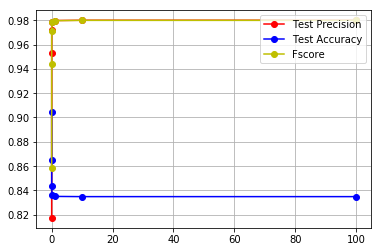

In [19]:
acc_train_logreg = []
acc_test_logreg = []
c_logreg = []
fscore_test_logreg.clear()
prec_test_logreg.clear()


# Call the function logreg_model.
for c in c_values:
    logreg_model_L1(c, X_transformed_train, y_train, X_transformed_test, y_test)
    
plt.plot(c_logreg, prec_test_logreg, 'ro-') 
plt.plot(c_logreg, acc_test_logreg,'bo-') 
plt.plot(c_logreg, fscore_test_logreg,'yo-')
plt.grid()
plt.legend(['Test Precision', 'Test Accuracy','Fscore'], loc='upper right')
    


## 4.3.2 Using L1 Regularization with PCA


In [20]:
from sklearn.decomposition import PCA
pca = PCA(.95)
pca_x_transformed_train = pca.fit_transform(X_transformed_train)
pca_x_transformed_test = pca.transform(X_transformed_test)
pca.n_components_

7

C:\Users\zafir\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


For C = 0.000100
Accuracy on training data = 0.909856
Accuracy on test data = 0.904134
Precision on test data = 0.817458
Recal on test data = 0.904134
fscore on test data = 0.858614


C:\Users\zafir\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\zafir\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


For C = 0.001000
Accuracy on training data = 0.873582
Accuracy on test data = 0.865301
Precision on test data = 0.953265
Recal on test data = 0.951285
fscore on test data = 0.943819


C:\Users\zafir\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


For C = 0.010000
Accuracy on training data = 0.850315
Accuracy on test data = 0.843627
Precision on test data = 0.971903
Recal on test data = 0.972291
fscore on test data = 0.970745


C:\Users\zafir\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


For C = 0.100000
Accuracy on training data = 0.844880
Accuracy on test data = 0.836583
Precision on test data = 0.978338
Recal on test data = 0.978771
fscore on test data = 0.978116


C:\Users\zafir\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


For C = 1.000000
Accuracy on training data = 0.844269
Accuracy on test data = 0.835138
Precision on test data = 0.979709
Recal on test data = 0.980112
fscore on test data = 0.979593


C:\Users\zafir\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


For C = 10.000000
Accuracy on training data = 0.844086
Accuracy on test data = 0.834957
Precision on test data = 0.979940
Recal on test data = 0.980335
fscore on test data = 0.979834


C:\Users\zafir\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


For C = 100.000000
Accuracy on training data = 0.844147
Accuracy on test data = 0.834957
Precision on test data = 0.979940
Recal on test data = 0.980335
fscore on test data = 0.979834


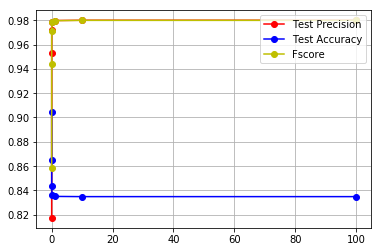

In [21]:
acc_train_logreg = []
acc_test_logreg = []
c_logreg = []
fscore_test_logreg.clear()
prec_test_logreg.clear()

# Call the function logreg_model.
for c in c_values:
    logreg_model_L1(c, X_transformed_train, y_train, X_transformed_test, y_test)
    
plt.plot(c_logreg, prec_test_logreg, 'ro-') 
plt.plot(c_logreg, acc_test_logreg,'bo-') 
plt.plot(c_logreg, fscore_test_logreg,'yo-')
plt.grid()
plt.legend(['Test Precision', 'Test Accuracy', 'Fscore'], loc='upper right')
    

## 4.3.3 Using L2 Regularization without PCA

C:\Users\zafir\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


For C = 0.000100
Accuracy on training data = 0.869063
Accuracy on test data = 0.860786
Precision on test data = 0.957198
Recal on test data = 0.955978
fscore on test data = 0.950262


C:\Users\zafir\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


For C = 0.001000
Accuracy on training data = 0.856422
Accuracy on test data = 0.848142
Precision on test data = 0.968378
Recal on test data = 0.968492
fscore on test data = 0.966183


C:\Users\zafir\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


For C = 0.010000
Accuracy on training data = 0.849766
Accuracy on test data = 0.843085
Precision on test data = 0.973082
Recal on test data = 0.973408
fscore on test data = 0.971978


C:\Users\zafir\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


For C = 0.100000
Accuracy on training data = 0.845857
Accuracy on test data = 0.837486
Precision on test data = 0.977188
Recal on test data = 0.977654
fscore on test data = 0.976896


C:\Users\zafir\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


For C = 1.000000
Accuracy on training data = 0.844575
Accuracy on test data = 0.835860
Precision on test data = 0.979259
Recal on test data = 0.979665
fscore on test data = 0.979086


C:\Users\zafir\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


For C = 10.000000
Accuracy on training data = 0.844453
Accuracy on test data = 0.835318
Precision on test data = 0.979950
Recal on test data = 0.980335
fscore on test data = 0.979811


C:\Users\zafir\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


For C = 100.000000
Accuracy on training data = 0.844392
Accuracy on test data = 0.834957
Precision on test data = 0.979940
Recal on test data = 0.980335
fscore on test data = 0.979834


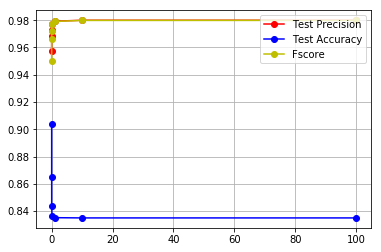

In [22]:
acc_train_logreg_L2 = [] 
acc_test_logreg_L2 = []
Yhat_test_logreg_L2 = []
c_logreg_L2 = []
fscore_test_logreg.clear()
prec_test_logreg.clear()
# Call the function logreg_model.
for c in c_values:
    logreg_model_L2(c, X_transformed_train, y_train, X_transformed_test, y_test)
    
plt.plot(c_logreg, prec_test_logreg, 'ro-') 
plt.plot(c_logreg, acc_test_logreg,'bo-') 
plt.plot(c_logreg, fscore_test_logreg,'yo-') 
plt.grid()
plt.legend(['Test Precision', 'Test Accuracy', 'Fscore'], loc='upper right')
    


## 4.3.4 Using L2 regularization with PCA

In [23]:
pca = PCA(.95)
pca_x_transformed_train = pca.fit_transform(X_transformed_train)
pca_x_transformed_test = pca.transform(X_transformed_test)
pca.n_components_

7

C:\Users\zafir\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


For C = 0.000100
Accuracy on training data = 0.869063
Accuracy on test data = 0.860786
Precision on test data = 0.957198
Recal on test data = 0.955978
fscore on test data = 0.950262


C:\Users\zafir\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


For C = 0.001000
Accuracy on training data = 0.856422
Accuracy on test data = 0.848142
Precision on test data = 0.968378
Recal on test data = 0.968492
fscore on test data = 0.966183


C:\Users\zafir\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


For C = 0.010000
Accuracy on training data = 0.849766
Accuracy on test data = 0.843085
Precision on test data = 0.973082
Recal on test data = 0.973408
fscore on test data = 0.971978


C:\Users\zafir\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


For C = 0.100000
Accuracy on training data = 0.845857
Accuracy on test data = 0.837486
Precision on test data = 0.977188
Recal on test data = 0.977654
fscore on test data = 0.976896


C:\Users\zafir\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


For C = 1.000000
Accuracy on training data = 0.844575
Accuracy on test data = 0.835860
Precision on test data = 0.979259
Recal on test data = 0.979665
fscore on test data = 0.979086


C:\Users\zafir\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


For C = 10.000000
Accuracy on training data = 0.844453
Accuracy on test data = 0.835318
Precision on test data = 0.979950
Recal on test data = 0.980335
fscore on test data = 0.979811


C:\Users\zafir\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


For C = 100.000000
Accuracy on training data = 0.844392
Accuracy on test data = 0.834957
Precision on test data = 0.979940
Recal on test data = 0.980335
fscore on test data = 0.979834


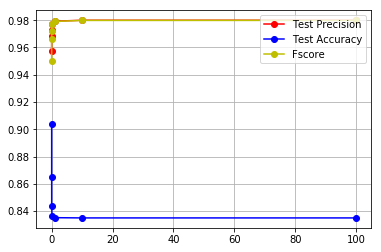

In [24]:
acc_train_logreg_L2 = [] 
acc_test_logreg_L2 = []
Yhat_test_logreg_L2 = []
c_logreg_L2 = []
fscore_test_logreg.clear()
prec_test_logreg.clear()
# Call the function logreg_model.
for c in c_values:
    logreg_model_L2(c, X_transformed_train, y_train, X_transformed_test, y_test)
    
plt.plot(c_logreg, prec_test_logreg, 'ro-') 
plt.plot(c_logreg, acc_test_logreg,'bo-') 
plt.plot(c_logreg, fscore_test_logreg,'yo-') 
plt.grid()
plt.legend(['Test Precision', 'Test Accuracy', 'Fscore'], loc='upper right')

# 5. Support Vector Machine (SVM)

## 5.1 Using Linear Kernel

In [25]:
acc_train_svm_linear = []
acc_test_svm_linear = []
c_svm_linear = []
prec_test_svm_linear = []
fscore_test_svm_linear = []

In [26]:
from sklearn import svm

def svm_linear(c, X_train, Y_train, X_test, Y_test):
    
    svc_linear = svm.SVC(probability = False, kernel = 'linear', C = c)

    svc_linear.fit(X_train, Y_train)

    Yhat_svc_linear_train = svc_linear.predict(X_train)
    acc_train = np.mean(Yhat_svc_linear_train == Y_train)
    
    # Adding testing accuracy to acc_train_svm
    acc_train_svm_linear.append(acc_train)
    print('Train Accuracy = {0:f}'.format(acc_train))
    
    Yhat_svc_linear_test = svc_linear.predict(X_test)
    acc_test = np.mean(Yhat_svc_linear_test == Y_test)
    
    # Adding testing accuracy to acc_test_svm
    acc_test_svm_linear.append(acc_test)
    print('Test Accuracy = {0:f}'.format(acc_test))
    prec , recal , fscore,_ = precision_recall_fscore_support(Y_test, Yhat_svc_linear_test, average = 'weighted')
    prec_test_svm_linear.append(prec)
    fscore_test_svm_linear.append(fscore)
    print("Precision on test data = %f" % prec)
    print("Recal on test data = %f" % recal)
    print("fscore on test data = %f" % fscore)
    
    
    # Appending value of c for graphing purposes
    c_svm_linear.append(c)
    

In [27]:
print(c_values)
for c in c_values:
    svm_linear(c,x_train,y_train, x_test, y_test)


[0.0001, 0.001, 0.01, 0.1, 1, 10, 100]


C:\Users\zafir\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Train Accuracy = 0.873277
Test Accuracy = 0.865662
Precision on test data = 0.952854
Recal on test data = 0.950838
fscore on test data = 0.943207


C:\Users\zafir\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Train Accuracy = 0.857094
Test Accuracy = 0.848323
Precision on test data = 0.969211
Recal on test data = 0.969162
fscore on test data = 0.966880


C:\Users\zafir\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Train Accuracy = 0.850071
Test Accuracy = 0.842363
Precision on test data = 0.972983
Recal on test data = 0.973408
fscore on test data = 0.972049


C:\Users\zafir\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Train Accuracy = 0.846468
Test Accuracy = 0.837305
Precision on test data = 0.978856
Recal on test data = 0.979218
fscore on test data = 0.978526


C:\Users\zafir\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Train Accuracy = 0.845308
Test Accuracy = 0.836763
Precision on test data = 0.979541
Recal on test data = 0.979888
fscore on test data = 0.979255


C:\Users\zafir\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Train Accuracy = 0.845308
Test Accuracy = 0.836583
Precision on test data = 0.979769
Recal on test data = 0.980112
fscore on test data = 0.979498


C:\Users\zafir\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Train Accuracy = 0.845247
Test Accuracy = 0.836583
Precision on test data = 0.979769
Recal on test data = 0.980112
fscore on test data = 0.979498


[0.8656623201523048, 0.8483229362379451, 0.842362523017384, 0.8373052027090291, 0.8367633469617053, 0.8365827283792641, 0.8365827283792641]


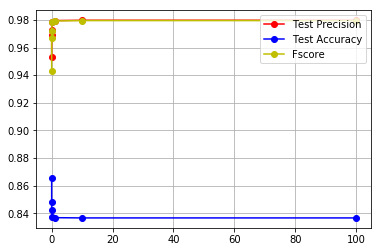

In [28]:
print(acc_test_svm_linear)
# Plot training accuracy(Y-axis) v/s 'c' on X - Axis.
# Plot test accuracy(Y-Axis) v/s 'c' on X - Axis.

plt.plot(c_svm_linear, prec_test_svm_linear, 'ro-') 
plt.plot(c_svm_linear, acc_test_svm_linear,'bo-') 
plt.plot(c_svm_linear, fscore_test_svm_linear,'yo-') 
plt.grid()

# Use the following function to have a legend
plt.legend(['Test Precision', 'Test Accuracy','Fscore'], loc='upper right')

## 5.2 Using Radial Basis Function (RBF) Kernel

In [29]:
acc_train_svm_rbf = []
acc_test_svm_rbf = []
c_svm_rbf = []
prec_test_svm_rbf = []
fscore_test_svm_rbf = []

In [30]:
from sklearn import svm

def svm_rbf(c,X_train,Y_train, X_test, Y_test):

    svc_rbf = svm.SVC(probability = False, kernel = 'rbf', C = c)
    
    svc_rbf.fit(X_train, Y_train)

    Yhat_svc_rbf_train = svc_rbf.predict(X_train)
    acc_train = np.mean(Yhat_svc_rbf_train == Y_train)
    
    # Adding testing accuracy to acc_train_svm
    acc_train_svm_rbf.append(acc_train)
    print('Train Accuracy = {0:f}'.format(acc_train))
    
    Yhat_svc_rbf_test = svc_rbf.predict(X_test)
    acc_test = np.mean(Yhat_svc_rbf_test == Y_test)
    
    # Adding testing accuracy to acc_test_svm
    acc_test_svm_rbf.append(acc_test)
    print('Test Accuracy = {0:f}'.format(acc_test))
    prec , recal , fscore,_ = precision_recall_fscore_support(Y_test, Yhat_svc_rbf_test, average = 'weighted')
    prec_test_svm_rbf.append(prec)
    fscore_test_svm_rbf.append(fscore)
    print("Precision on test data = %f" % prec)
    print("Recal on test data = %f" % recal)
    print("fscore on test data = %f" % fscore)
    # Appending value of c for graphing purposes
    c_svm_rbf.append(c)
    

In [31]:
for c in c_values:
    svm_rbf(c,x_train,y_train, x_test, y_test)

C:\Users\zafir\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\zafir\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Train Accuracy = 0.909856
Test Accuracy = 0.904134
Precision on test data = 0.817458
Recal on test data = 0.904134
fscore on test data = 0.858614


C:\Users\zafir\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\zafir\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\zafir\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Train Accuracy = 0.909856
Test Accuracy = 0.904134
Precision on test data = 0.817458
Recal on test data = 0.904134
fscore on test data = 0.858614


C:\Users\zafir\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\zafir\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\zafir\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Train Accuracy = 0.856788
Test Accuracy = 0.848142
Precision on test data = 0.969431
Recal on test data = 0.969385
fscore on test data = 0.967142


C:\Users\zafir\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\zafir\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Train Accuracy = 0.848422
Test Accuracy = 0.840556
Precision on test data = 0.976723
Recal on test data = 0.976983
fscore on test data = 0.975957


C:\Users\zafir\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\zafir\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Train Accuracy = 0.845247
Test Accuracy = 0.836944
Precision on test data = 0.978356
Recal on test data = 0.978771
fscore on test data = 0.978090


C:\Users\zafir\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\zafir\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Train Accuracy = 0.845369
Test Accuracy = 0.836221
Precision on test data = 0.979750
Recal on test data = 0.980112
fscore on test data = 0.979522


C:\Users\zafir\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\zafir\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Train Accuracy = 0.844453
Test Accuracy = 0.835499
Precision on test data = 0.979720
Recal on test data = 0.980112
fscore on test data = 0.979569


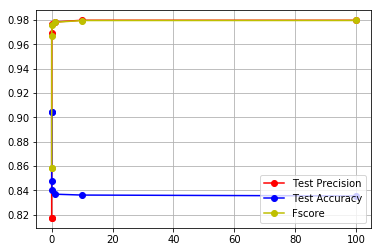

In [32]:
plt.plot(c_svm_rbf, prec_test_svm_rbf, 'ro-') 
plt.plot(c_svm_rbf, acc_test_svm_rbf,'bo-') 
plt.plot(c_svm_rbf, fscore_test_svm_rbf,'yo-') 
plt.grid()
# Use the following function to have a legend
plt.legend(['Test Precision', 'Test Accuracy', 'Fscore'], loc='lower right')

## 5.3 Using Polynomial Kernel

In [33]:
acc_train_svm_poly = []
acc_test_svm_poly = []
c_svm_poly = []
prec_test_svm_poly = []
fscore_test_svm_poly = []

In [34]:
def svm_polynomial(c,X_train,Y_train, X_test, Y_test):

    svc_polynomial = svm.SVC(probability = False, kernel = 'poly', C = c)

    svc_polynomial.fit(X_train, Y_train)

    Yhat_svc_polynomial_train = svc_polynomial.predict(X_test)
    acc_train = np.mean(Yhat_svc_polynomial_train == Y_train)
    
    # Adding testing accuracy to acc_train_svm
    acc_train_svm_poly.append(acc_train)
    print('Train Accuracy = {0:f}'.format(acc_train))
    
    Yhat_svc_polynomial_test = svc_polynomial.predict(X_test)
    acc_test = np.mean(Yhat_svc_polynomial_test == Y_test)
    
    # Adding testing accuracy to acc_test_svm
    acc_test_svm_poly.append(acc_test)
    print('Test Accuracy = {0:f}'.format(acc_test))
    prec , recal , fscore,_ = precision_recall_fscore_support(Y_test, Yhat_svc_polynomial_test, average = 'weighted')
    prec_test_svm_poly.append(prec)
    fscore_test_svm_poly.append(fscore)
    print("Precision on test data = %f" % prec)
    print("Recal on test data = %f" % recal)
    print("fscore on test data = %f" % fscore)
    
    # Appending value of c for graphing purposes
    c_svm_poly.append(c)

In [35]:
for c in c_values:
    svm_polynomial(c,x_train,y_train, x_test, y_test)

C:\Users\zafir\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\zafir\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Train Accuracy = 0.872488
Test Accuracy = 0.867288
Precision on test data = 0.951688
Recal on test data = 0.949274
fscore on test data = 0.940945


C:\Users\zafir\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\zafir\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Train Accuracy = 0.862414
Test Accuracy = 0.857354
Precision on test data = 0.959451
Recal on test data = 0.958883
fscore on test data = 0.954226


C:\Users\zafir\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\zafir\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Train Accuracy = 0.852339
Test Accuracy = 0.847420
Precision on test data = 0.968218
Recal on test data = 0.968492
fscore on test data = 0.966274


C:\Users\zafir\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\zafir\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Train Accuracy = 0.849042
Test Accuracy = 0.844169
Precision on test data = 0.970720
Recal on test data = 0.971173
fscore on test data = 0.969507


C:\Users\zafir\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\zafir\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Train Accuracy = 0.844646
Test Accuracy = 0.839834
Precision on test data = 0.975667
Recal on test data = 0.976089
fscore on test data = 0.975085


C:\Users\zafir\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\zafir\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Train Accuracy = 0.842081
Test Accuracy = 0.837305
Precision on test data = 0.977418
Recal on test data = 0.977877
fscore on test data = 0.977140


C:\Users\zafir\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\zafir\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Train Accuracy = 0.841348
Test Accuracy = 0.836583
Precision on test data = 0.978815
Recal on test data = 0.979218
fscore on test data = 0.978576


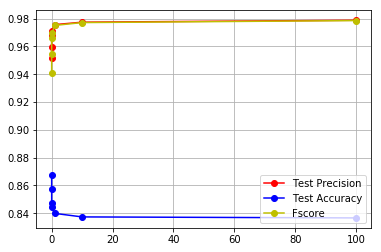

In [36]:
plt.plot(c_svm_poly,prec_test_svm_poly, 'ro-') 
plt.plot(c_svm_poly,acc_test_svm_poly,'bo-')
plt.plot(c_svm_poly,fscore_test_svm_poly,'yo-') 
plt.grid()
# Use the following function to have a legend
plt.legend(['Test Precision', 'Test Accuracy','Fscore'], loc='lower right')


# 6. Neural Networks
In the following section, we will run our data set through various neural networks with different hyper parameters. We will vary the activation function (tanh, reLU, sigmoid), the number of inputs in the hidden layer (10, 100, 200), and the number of hidden layers (1, 2, 5, with 100 nodes in each hidden layer). Weights and biases will be initialized randomly.  

In [37]:
class Metrics(Callback):
    def on_train_begin(self, logs={}):
     self.val_f1s = []
     self.val_recalls = []
     self.val_precisions = []
 
    def on_epoch_end(self, epoch, logs={}):
     val_predict = (np.asarray(self.model.predict(self.validation_data[0])).round())
     val_targ = self.validation_data[1]
     _val_f1 = f1_score(val_targ, val_predict)
     _val_recall = recall_score(val_targ, val_predict)
     _val_precision = precision_score(val_targ, val_predict)
    
     self.val_f1s.append(_val_f1)
     self.val_recalls.append(_val_recall)
     self.val_precisions.append(_val_precision)
        
     print (" — val_f1: %f — val_precision: %f — val_recall %f" % 
            (_val_f1, _val_precision, _val_recall))
     return

metrics = Metrics()

# Build and compile our network with user given parameters
def neural_network(nin, nh, nout, nhl, act):
    model = Sequential();
    for x in range(0,nhl):
        model.add(Dense(nh, input_shape=(nin,), activation=act, name="hidden"+str(x)))
    model.add(Dense(nout, activation="sigmoid", name="output"))  
    # Compile model
    opt = optimizers.Adam(lr=0.001) 
    model.compile(optimizer=opt, 
             loss="binary_crossentropy",
             metrics=["accuracy"])  
    return model

# Train and validate our network on training and test data
def train_network(model, x_train, y_train, x_test, y_test):
    history = model.fit(x_train, y_train, epochs=10, batch_size=100, 
                validation_data=(x_test, y_test), callbacks=[metrics], verbose=1)
    return history

# Plot network accuracy
def plot_acc(history, title):
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title(title)
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['acc', 'val_acc'], loc='lower right')
    plt.show()

# Plot network loss
def plot_loss(history, title):
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title(title)
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['acc', 'val_acc'], loc='upper right')
    plt.show()
    


# 6.1 Network 8-100-1, Sigmoid

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Train on 13423 samples, validate on 4475 samples
Epoch 1/10
13423/13423 [==============================] - 1s 61us/step - loss: 0.1936 - acc: 0.9391 - val_loss: 0.1261 - val_acc: 0.9584
 — val_f1: 0.728863 — val_precision: 0.972763 — val_recall 0.582751
Epoch 2/10
13423/13423 [==============================] - 0s 19us/step - loss: 0.1096 - acc: 0.9668 - val_loss: 0.1034 - val_acc: 0.9687
 — val_f1: 0.810811 — val_precision: 0.964630 — val_recall 0.699301
Epoch 3/10
13423/13423 [==============================] - 0s 18us/step - loss: 0.0957 - acc: 0.9713 - val_loss: 0.0950 - val_acc: 0.9712
 — val_f1: 0.830931 — val_precision: 0.949102 — val_recall 0.738928
Epoch 4/10
13423/13423 [==============================] - 0s 18us/step - loss: 0.0892 - acc: 0.9735 - val_loss: 0.0903 - val_acc: 0.9716
 — val_f1: 0.833552 — val_precision: 0.952096 — val_recall 0.741259
Epoch 5/10


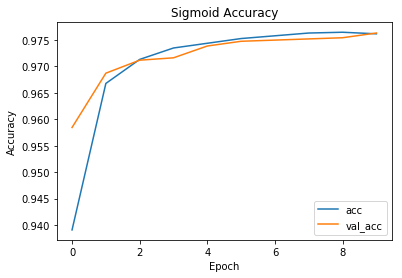

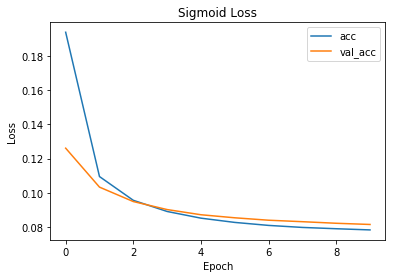

Validation Accuracy = 0.976313


In [38]:
K.clear_session()

modelArr = []
historyArr = []
modelNameArr = []
# Number of nodes in input layer = number of features = 8
nin = x_train.shape[1];
# Number of hidden layer nodes
nh = 100;
# Number of output nodes
nout = 1;


model_sig = neural_network(nin, nh, nout, 1, "sigmoid")
sig_history = train_network(model_sig, x_train, y_train, x_test, y_test);
model_sig.summary()
plot_acc(sig_history, "Sigmoid Accuracy")
plot_loss(sig_history, "Sigmoid Loss")

modelArr.append(model_sig)
historyArr.append(sig_history)
modelNameArr.append("model_sig")

score, acc = model_sig.evaluate(x_test, y_test, verbose = 0)
print("Validation Accuracy = %f" % acc)


## 6.2 Network 8-100-1, ReLU

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
hidden0 (Dense)              (None, 100)               900       
_________________________________________________________________
output (Dense)               (None, 1)                 101       
Total params: 1,001
Trainable params: 1,001
Non-trainable params: 0
_________________________________________________________________
Train on 13423 samples, validate on 4475 samples
Epoch 1/10
13423/13423 [==============================] - 1s 57us/step - loss: 0.3263 - acc: 0.9169 - val_loss: 0.1220 - val_acc: 0.9727
 — val_f1: 0.839895 — val_precision: 0.960961 — val_recall 0.745921
Epoch 2/10
13423/13423 [==============================] - 0s 22us/step - loss: 0.0944 - acc: 0.9753 - val_loss: 0.0851 - val_acc: 0.9747
 — val_f1: 0.854569 — val_precision: 0.954023 — val_recall 0.773893
Epoch 3/10
13423/13423 [==============================] - 0s 26us/step - loss

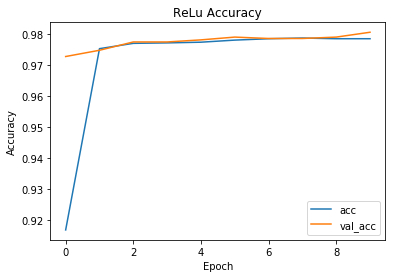

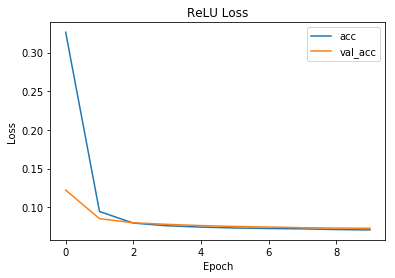

Accuracy = 0.980559


In [39]:
nh = 100;
    
model_relu = neural_network(nin, nh, nout, 1, "relu")
model_relu.summary()
relu_history = train_network(model_relu, x_train, y_train, x_test, y_test);
plot_acc(relu_history, "ReLu Accuracy")
plot_loss(relu_history, "ReLU Loss")

modelArr.append(model_relu)
historyArr.append(relu_history)
modelNameArr.append("model_relu")

score, acc = model_relu.evaluate(x_test, y_test, verbose = 0)
print("Accuracy = %f" % acc)

## 6.3 Network 8-100-1, tanh

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
hidden0 (Dense)              (None, 100)               900       
_________________________________________________________________
output (Dense)               (None, 1)                 101       
Total params: 1,001
Trainable params: 1,001
Non-trainable params: 0
_________________________________________________________________
Train on 13423 samples, validate on 4475 samples
Epoch 1/10
13423/13423 [==============================] - 1s 56us/step - loss: 0.2659 - acc: 0.9646 - val_loss: 0.1113 - val_acc: 0.9750
 — val_f1: 0.854922 — val_precision: 0.962099 — val_recall 0.769231
Epoch 2/10
13423/13423 [==============================] - 0s 19us/step - loss: 0.0905 - acc: 0.9761 - val_loss: 0.0839 - val_acc: 0.9763
 — val_f1: 0.866162 — val_precision: 0.944904 — val_recall 0.799534
Epoch 3/10
13423/13423 [==============================] - 0s 20us/step - loss

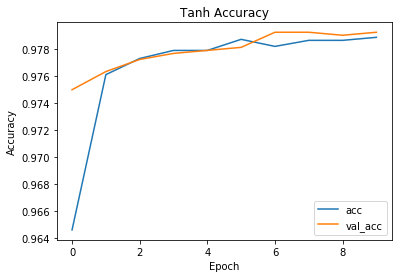

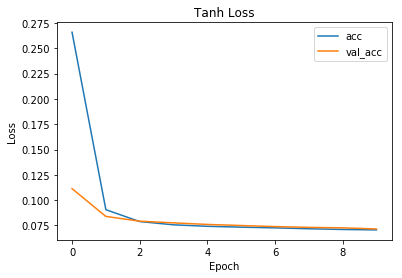

Accuracy = 0.979218


In [40]:
nh = 100;
    
model_tanh = neural_network(nin, nh, nout, 1, "relu")
model_tanh.summary()
tanh_history = train_network(model_tanh, x_train, y_train, x_test, y_test);
plot_acc(tanh_history, "Tanh Accuracy")
plot_loss(tanh_history, "Tanh Loss")

modelArr.append(model_tanh)
historyArr.append(tanh_history)
modelNameArr.append("model_tanh")

score, acc = model_tanh.evaluate(x_test, y_test, verbose = 0)
print("Accuracy = %f" % acc)

## 6.4 Network 8-10-1, sigmoid

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
hidden0 (Dense)              (None, 10)                90        
_________________________________________________________________
output (Dense)               (None, 1)                 11        
Total params: 101
Trainable params: 101
Non-trainable params: 0
_________________________________________________________________
Train on 13423 samples, validate on 4475 samples
Epoch 1/10
13423/13423 [==============================] - 1s 50us/step - loss: 0.4114 - acc: 0.9097 - val_loss: 0.3172 - val_acc: 0.9041
 — val_f1: 0.000000 — val_precision: 0.000000 — val_recall 0.000000
Epoch 2/10
13423/13423 [==============================] - 0s 11us/step - loss: 0.2580 - acc: 0.9099 - val_loss: 0.2234 - val_acc: 0.9041


C:\Users\zafir\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\zafir\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\zafir\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


 — val_f1: 0.000000 — val_precision: 0.000000 — val_recall 0.000000
Epoch 3/10
13423/13423 [==============================] - 0s 11us/step - loss: 0.1942 - acc: 0.9165 - val_loss: 0.1784 - val_acc: 0.9397


C:\Users\zafir\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


 — val_f1: 0.542373 — val_precision: 0.993789 — val_recall 0.372960
Epoch 4/10
13423/13423 [==============================] - 0s 11us/step - loss: 0.1622 - acc: 0.9462 - val_loss: 0.1576 - val_acc: 0.9508
 — val_f1: 0.656250 — val_precision: 0.995261 — val_recall 0.489510
Epoch 5/10
13423/13423 [==============================] - 0s 11us/step - loss: 0.1462 - acc: 0.9550 - val_loss: 0.1446 - val_acc: 0.9571
 — val_f1: 0.714286 — val_precision: 0.987654 — val_recall 0.559441
Epoch 6/10
13423/13423 [==============================] - 0s 12us/step - loss: 0.1350 - acc: 0.9610 - val_loss: 0.1346 - val_acc: 0.9620
 — val_f1: 0.757835 — val_precision: 0.974359 — val_recall 0.620047
Epoch 7/10
13423/13423 [==============================] - 0s 11us/step - loss: 0.1260 - acc: 0.9651 - val_loss: 0.1262 - val_acc: 0.9667
 — val_f1: 0.795048 — val_precision: 0.969799 — val_recall 0.673660
Epoch 8/10
13423/13423 [==============================] - 0s 12us/step - loss: 0.1185 - acc: 0.9689 - val_loss: 

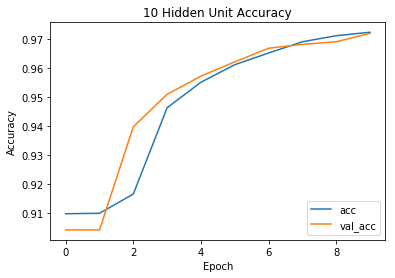

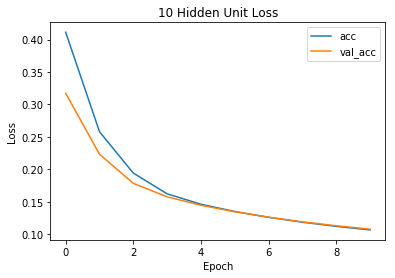

Accuracy = 0.971844


In [41]:
# We are changing the number of hidden units here
nh = 10;
    
model_ten = neural_network(nin, nh, nout, 1, "sigmoid")
model_ten.summary()
ten_history = train_network(model_ten, x_train, y_train, x_test, y_test);
plot_acc(ten_history, "10 Hidden Unit Accuracy")
plot_loss(ten_history, "10 Hidden Unit Loss")

modelArr.append(model_ten)
historyArr.append(ten_history)
modelNameArr.append("model_ten")

score, acc = model_ten.evaluate(x_test, y_test, verbose = 0)
print("Accuracy = %f" % acc)

## 6.5 Network 8-200-1, sigmoid

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
hidden0 (Dense)              (None, 200)               1800      
_________________________________________________________________
output (Dense)               (None, 1)                 201       
Total params: 2,001
Trainable params: 2,001
Non-trainable params: 0
_________________________________________________________________
Train on 13423 samples, validate on 4475 samples
Epoch 1/10
13423/13423 [==============================] - 1s 63us/step - loss: 0.1737 - acc: 0.9534 - val_loss: 0.1120 - val_acc: 0.9651
 — val_f1: 0.785124 — val_precision: 0.959596 — val_recall 0.664336
Epoch 2/10
13423/13423 [==============================] - 0s 21us/step - loss: 0.1006 - acc: 0.9693 - val_loss: 0.0972 - val_acc: 0.9696
 — val_f1: 0.818182 — val_precision: 0.959248 — val_recall 0.713287
Epoch 3/10
13423/13423 [==============================] - 0s 23us/step - loss

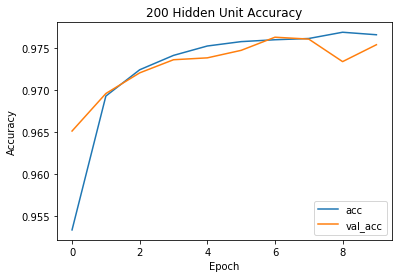

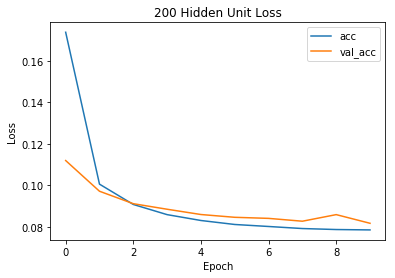

Accuracy = 0.975419


In [42]:
nh = 200;
    
model_twohund = neural_network(nin, nh, nout, 1, "sigmoid")
model_twohund.summary()
twohund_history = train_network(model_twohund, x_train, y_train, x_test, y_test);
plot_acc(twohund_history, "200 Hidden Unit Accuracy")
plot_loss(twohund_history, "200 Hidden Unit Loss")

modelArr.append(model_twohund)
historyArr.append(twohund_history)
modelNameArr.append("model_twohund")

score, acc = model_twohund.evaluate(x_test, y_test, verbose = 0)
print("Accuracy = %f" % acc)

## 6.6 Network 8-100-100-1 sigmoid

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
hidden0 (Dense)              (None, 100)               900       
_________________________________________________________________
hidden1 (Dense)              (None, 100)               10100     
_________________________________________________________________
output (Dense)               (None, 1)                 101       
Total params: 11,101
Trainable params: 11,101
Non-trainable params: 0
_________________________________________________________________
Train on 13423 samples, validate on 4475 samples
Epoch 1/10
13423/13423 [==============================] - 1s 75us/step - loss: 0.2135 - acc: 0.9271 - val_loss: 0.1204 - val_acc: 0.9616
 — val_f1: 0.757746 — val_precision: 0.957295 — val_recall 0.627040
Epoch 2/10
13423/13423 [==============================] - 0s 22us/step - loss: 0.0979 - acc: 0.9714 - val_loss: 0.0918 - val_acc: 0.9732
 — val_f1: 

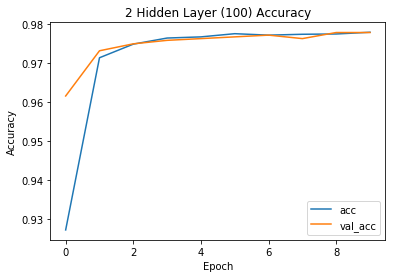

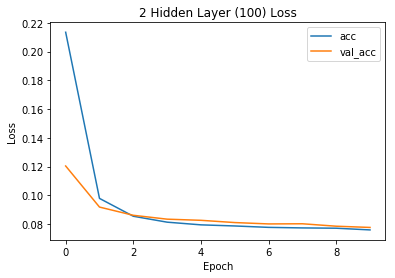

Accuracy = 0.977877


In [43]:
nh = 100;
num_layers = 2;
    
model_twolayer = neural_network(nin, nh, nout, num_layers, "sigmoid")
model_twolayer.summary()
twolayer_history = train_network(model_twolayer, x_train, y_train, x_test, y_test);
plot_acc(twolayer_history, "2 Hidden Layer (100) Accuracy")
plot_loss(twolayer_history, "2 Hidden Layer (100) Loss")

modelArr.append(model_twolayer)
historyArr.append(twolayer_history)
modelNameArr.append("model_twolayer")

score, acc = model_twolayer.evaluate(x_test, y_test, verbose = 0)
print("Accuracy = %f" % acc)

## 6.7 Network 8-100-100-100-100-100-1, sigmoid

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
hidden0 (Dense)              (None, 100)               900       
_________________________________________________________________
hidden1 (Dense)              (None, 100)               10100     
_________________________________________________________________
hidden2 (Dense)              (None, 100)               10100     
_________________________________________________________________
hidden3 (Dense)              (None, 100)               10100     
_________________________________________________________________
hidden4 (Dense)              (None, 100)               10100     
_________________________________________________________________
output (Dense)               (None, 1)                 101       
Total params: 41,401
Trainable params: 41,401
Non-trainable params: 0
_________________________________________________________________
Train 

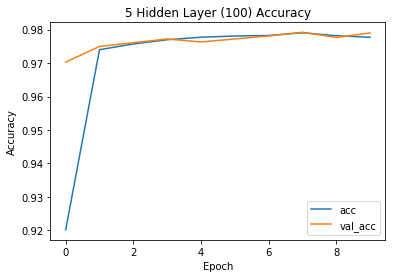

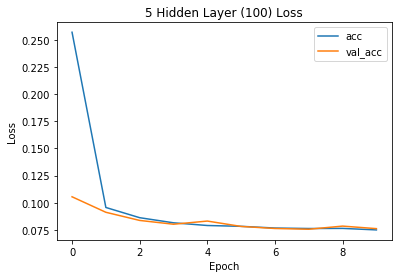

Accuracy = 0.978994


In [44]:
nh = 100;
num_layers = 5;
    
model_fivelayer = neural_network(nin, nh, nout, num_layers, "sigmoid")
model_fivelayer.summary()
fivelayer_history = train_network(model_fivelayer, x_train, y_train, x_test, y_test);
plot_acc(fivelayer_history, "5 Hidden Layer (100) Accuracy")
plot_loss(fivelayer_history, "5 Hidden Layer (100) Loss")

modelArr.append(model_fivelayer)
historyArr.append(fivelayer_history)
modelNameArr.append("model_fivelayer")

score, acc = model_fivelayer.evaluate(x_test, y_test, verbose = 0)
print("Accuracy = %f" % acc)

## Accuracy Graphs of All Models

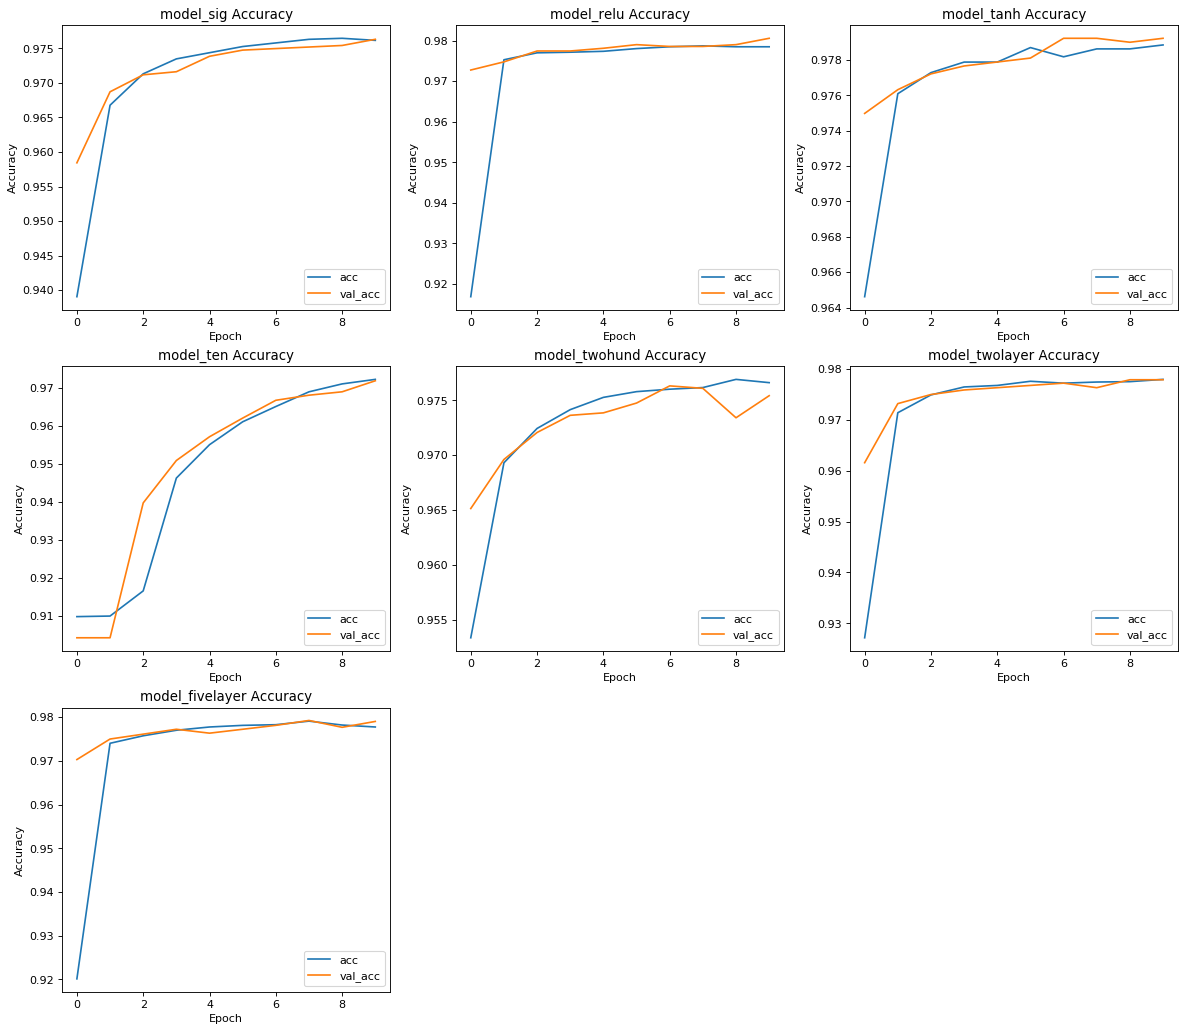

In [45]:
fig=plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')
fig.tight_layout()

for index, history in enumerate(historyArr):
    plt.subplot(3,3,index+1)
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title(modelNameArr[index] + " Accuracy")
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['acc', 'val_acc'], loc='lower right')

plt.show()

## Loss Graphs of All Models

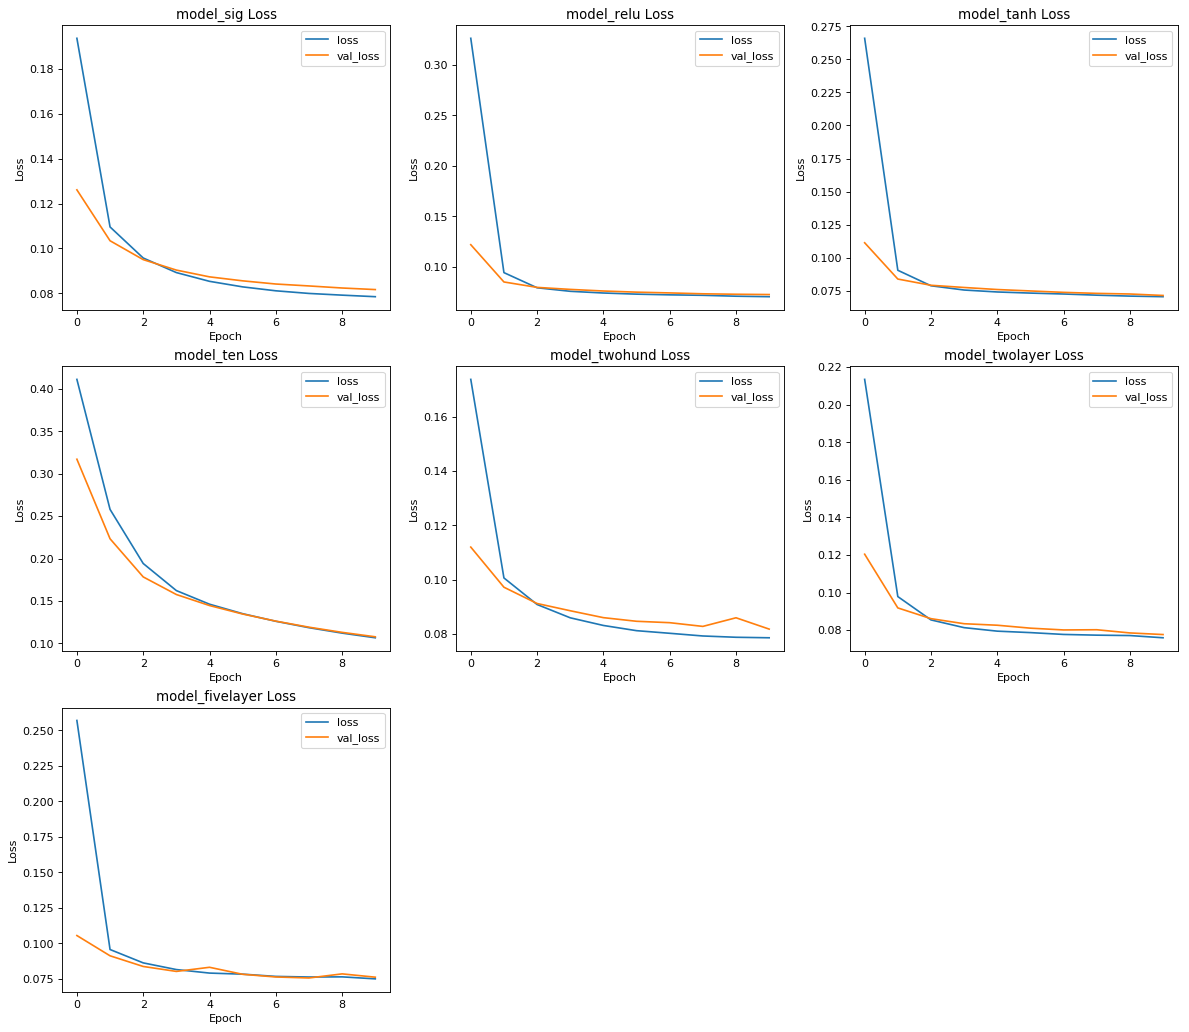

In [46]:
fig=plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')
fig.tight_layout()

for index, history in enumerate(historyArr):
    plt.subplot(3,3,index+1)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title(modelNameArr[index] + " Loss")
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['loss', 'val_loss'], loc='upper right')

plt.show()

## Final Accuracies of all models after 10 Epochs

In [47]:
for index, model in enumerate(modelArr):
    score, acc = model.evaluate(x_test, y_test, verbose = 0)
    print(modelNameArr[index] + " Validation Accuracy = " + "{:.3%}".format(acc))

print('\n')

for index, history in enumerate(historyArr):
    
    print(modelNameArr[index] + " Train Accuracy = " + 
          "{:.3%}".format(history.history["acc"][9]))

model_sig Validation Accuracy = 97.631%
model_relu Validation Accuracy = 98.056%
model_tanh Validation Accuracy = 97.922%
model_ten Validation Accuracy = 97.184%
model_twohund Validation Accuracy = 97.542%
model_twolayer Validation Accuracy = 97.788%
model_fivelayer Validation Accuracy = 97.899%


model_sig Train Accuracy = 97.616%
model_relu Train Accuracy = 97.847%
model_tanh Train Accuracy = 97.884%
model_ten Train Accuracy = 97.221%
model_twohund Train Accuracy = 97.661%
model_twolayer Train Accuracy = 97.795%
model_fivelayer Train Accuracy = 97.772%
